# Readme

This notebook is used to calculate the Optical backscatter of particles. 

# packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.simplefilter("ignore", UserWarning)
import pandas as pd
import csv
import sys
import array
import xarray as xr
import cmocean.cm as cmocean
def write_with_byte_inversion(f, tab):
    tab2write = array.array('f', tab.T.flatten())
    if sys.byteorder == 'little':
        tab2write.byteswap()
    f.write(tab2write)

dtype=np.float32
#topo_adjust to topo wi
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import FuncFormatter
import pathlib
from pathlib import Path
import os
import netCDF4
from netCDF4 import Dataset as nc
import glob
from glob import glob
import glidertools as gt
import gsw
import cmocean.cm as cmo

### Load data

In [2]:
filenames = 'C:/Users/rensk/OneDrive/Documenten/Physical Oceanography Master GU/mast thesis/Data/sg675/p6750*.nc'


gt.load.seaglider_show_variables(filenames)

information is based on file: C:/Users/rensk/OneDrive/Documenten/Physical Oceanography Master GU/mast thesis/Data/sg675\p6750150.nc


,dims,units,comment
name,,,
gc_data_pts,gc_event,1,
gc_depth,gc_event,meters,
gc_end_secs,gc_event,seconds since 1970-1-1 00:00:00,End of GC time in GMT epoch format
gc_flags,gc_event,,
gc_ob_vertv,gc_event,cm/s,
gc_pitch_ad,gc_event,1,
gc_pitch_ad_start,gc_event,1,
gc_pitch_ctl,gc_event,cm,
gc_pitch_errors,gc_event,1,


###  list of relevant variables

In [3]:
names = [
    'wlbb2fl_sig470nm_adjusted',
    'wlbb2fl_sig700nm_adjusted',
    'ctd_depth',
    'ctd_time',
    'eng_wlbb2fl_sig700nm',
    'eng_wlbb2fl_sig470nm',
    'eng_wlbb2fl_sig695nm',
]

In [4]:
# Remove duplicates by converting the list to a set and back to a list
names = list(names)

ds_dict = gt.load.seaglider_basestation_netCDFs(
    filenames, names,
    return_merged=False,
    keep_global_attrs=False
)


DIMENSION: sg_data_point
{ctd_time, eng_wlbb2fl_sig470nm, eng_wlbb2fl_sig700nm, wlbb2fl_sig470nm_adjusted, ctd_depth, wlbb2fl_sig700nm_adjusted, eng_wlbb2fl_sig695nm}


100%|██████████| 296/296 [00:07<00:00, 38.84it/s]


In [5]:
ds_backscatter = ds_dict['sg_data_point']
ds_work =  xr.open_dataset('ds_cal_1.nc')

# Calculation of backscatter 470 and 700 nm

In [7]:
# 700 nm
practical_sal = gsw.conversions.SP_from_SA(ds_work.salinity,ds_work.pressure, ds_work.longitude, ds_work.latitude)
tempC = ds_work.temp
salt = practical_sal
dives = ds_work.dives
depth = ds_work.ctd_depth
wavelength700 = 700
dark_count = 47
scale_factor_700 = 3.391e-6
bb_raw_700 = ds_backscatter.eng_wlbb2fl_sig700nm


bb700:
	Mask bad profiles based on deep values (depth=300m)
	Number of bad profiles = 21/592
	Zhang et al. (2009) correction
	Dark count correction
	Spike identification (spike window=7)
	Generating figure for despiking report


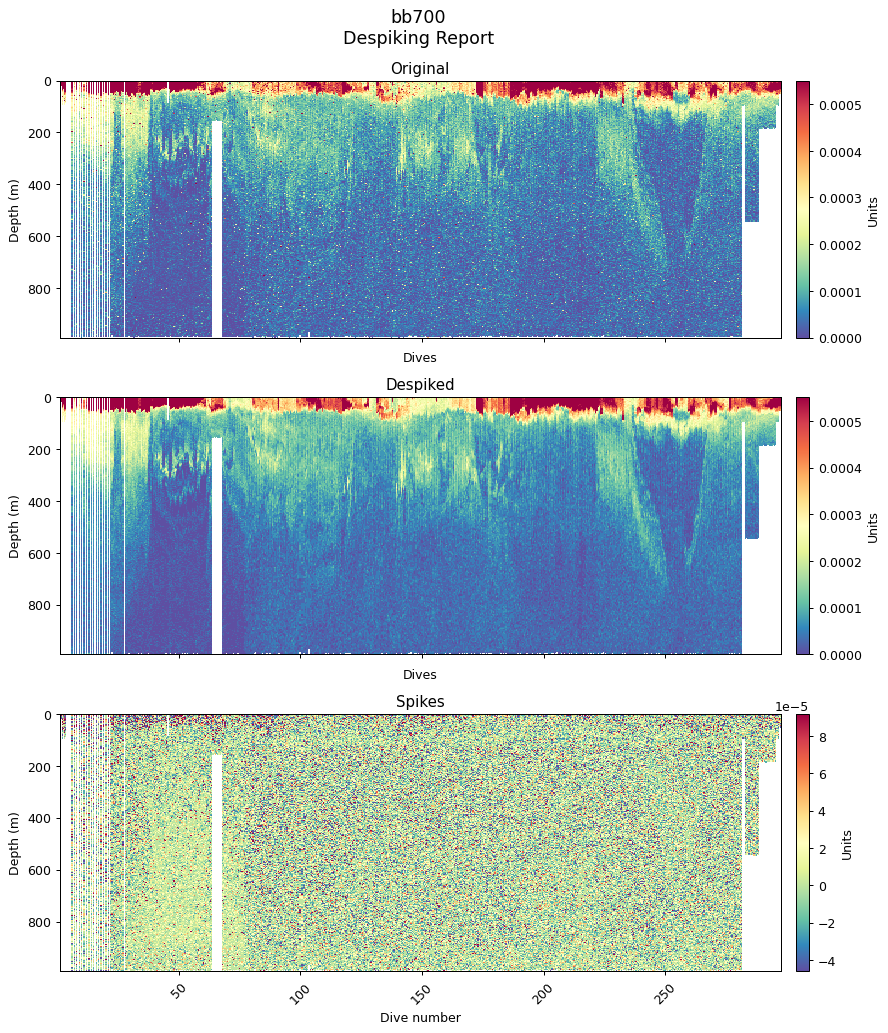

In [8]:
back_scatter_700 = gt.processing.calc_backscatter(bb_raw_700, tempC, salt, dives, depth, wavelength700, dark_count, scale_factor_700, spike_window=7, spike_method='nanmedian', iqr=0, profiles_ref_depth=300, deep_multiplier=1, deep_method='nanmedian', return_figure=True, verbose=True)

In [9]:
# 470 nm
tempC = ds_work.temp
salt = practical_sal
dives = ds_work.dives
depth = ds_work.ctd_depth
wavelength470 = 470
dark_count = 49
scale_factor_470 = 1.191e-5
bb_raw_470 = ds_backscatter.eng_wlbb2fl_sig470nm


bb470:
	Mask bad profiles based on deep values (depth=300m)
	Number of bad profiles = 61/592
	Zhang et al. (2009) correction
	Dark count correction
	Spike identification (spike window=7)
	Generating figure for despiking report


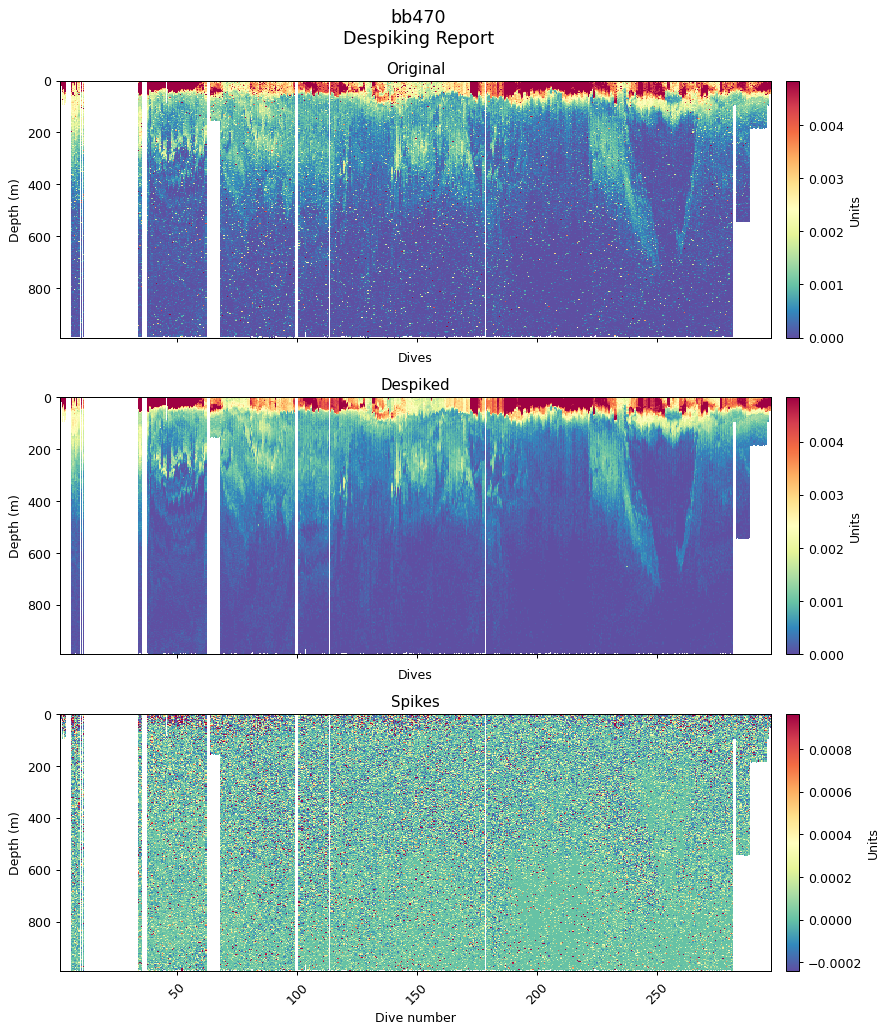

In [10]:
back_scatter_470 = gt.processing.calc_backscatter(bb_raw_470, tempC, salt, dives, depth, wavelength470, dark_count, scale_factor_470, spike_window=7, spike_method='median', iqr=0, profiles_ref_depth=300, deep_multiplier=1, deep_method='median', return_figure=True, verbose=True)

## spectral slope

In [11]:
# Define a safe log function that can handle arrays and replace log(0) with 0
def safe_log(value):
    # Use np.where to avoid evaluating log(0)
    return np.where(np.isclose(value, 0), 0, np.log(value))

spectral_slope = (safe_log(back_scatter_700[0]/back_scatter_470[0])/(np.log(470/700)))

# Create a DataArray for spectral_slope with the same dimension
spectral_slope = xr.DataArray(spectral_slope, dims="sg_data_point", name="spectral_slope")



# Add spectral_slope as a data variable to the dataset
ds_work['spectral_slope'] = spectral_slope

# Output the updated Dataset
print(ds_work)

<xarray.Dataset>
Dimensions:          (sg_data_point: 1011760)
Coordinates:
    longitude        (sg_data_point) float64 ...
    latitude         (sg_data_point) float64 ...
    ctd_depth        (sg_data_point) float64 0.3871 0.8966 ... 0.01038 -0.1323
    ctd_time_dt64    (sg_data_point) datetime64[ns] ...
    distance         (sg_data_point) float64 ...
    tot_distance     (sg_data_point) float64 ...
    dives            (sg_data_point) float64 1.0 1.0 1.0 ... 297.5 297.5 297.5
Dimensions without coordinates: sg_data_point
Data variables:
    temp             (sg_data_point) float64 nan nan nan nan ... nan nan nan
    salinity         (sg_data_point) float64 ...
    o2               (sg_data_point) float64 ...
    pressure         (sg_data_point) float64 ...
    spectral_slope   (sg_data_point) float64 nan nan nan nan ... nan nan nan
    backscatter_470  (sg_data_point) float64 ...
    backscatter_700  (sg_data_point) float64 ...
Attributes:
    description:  dataset including QC an


Physics Variable:
	Removing outliers with IQR * 1.5: 119344 obs
	Removing spikes with rolling median (spike window=7)
	Smoothing with Savitzky-Golay filter (window=11, order=2)


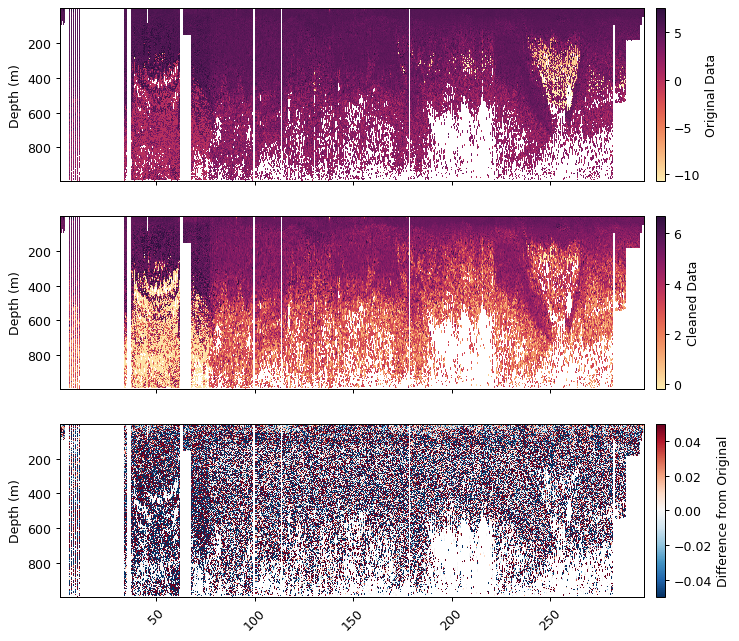

In [12]:
slope_qc = gt.calc_physics(ds_work.spectral_slope, ds_work.dives, ds_work.ctd_depth,
                          iqr=1.5, depth_threshold=0,
                          spike_window=7, spike_method='median',
                          savitzky_golay_window=11, savitzky_golay_order=2)

# PLOTTING
cmap = plt.get_cmap("RdBu_r")
fig, ax = plt.subplots(3, 1, figsize=[9, 8.5], sharex=True, dpi=90)

gt.plot(ds_work.dives, ds_work.ctd_depth, ds_work.spectral_slope, cmap=cmo.matter, ax=ax[0])
gt.plot(ds_work.dives, ds_work.ctd_depth, slope_qc, cmap=cmo.matter, ax=ax[1])
gt.plot(ds_work.dives, ds_work.ctd_depth, slope_qc - ds_work.spectral_slope, cmap=cmap, vmin=-0.05, vmax=0.05, ax=ax[2])

[a.set_xlabel('') for a in ax]

ax[0].cb.set_label('Original Data')
ax[1].cb.set_label('Cleaned Data')
ax[2].cb.set_label('Difference from Original')

plt.show()

# Create dataset with backscatter, chlorophyll and spectral slope

In [14]:
ds_work['spectral_slope'] = slope_qc
ds_work['backscatter_470'] = back_scatter_470[0]
ds_work['backscatter_700'] = back_scatter_700[0]
ds_work['chlorophyll'] = ds_backscatter.eng_wlbb2fl_sig695nm

In [15]:
ds_work.to_netcdf('ds_backsc.nc')

